# Joint angle encoding of hair plates

### Brandon Pratt

Characterize the joint angles in which CxHP8 neurons are active. CxHP8 activity is measured through calcium imaging.

Dataset is found at the following Dryad repository: 

In [1]:
# import python libraries
import os
import os.path
from os import listdir
from os.path import isfile, join
import math
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sea
import scipy.signal

from scipy import signal
from scipy.stats import norm
from scipy.stats import vonmises
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from scipy import stats
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from matplotlib.cm import ScalarMappable

### Import data

In [2]:
data_dir = "[Directory that contains the calcium imaging dataset dataset]"
save_dir = "[Directory where calicum imaging results will be saved]"
dataset = 'R48A07_R20C06_GCaMP7f_tdTomato.parquet'
data = pd.read_parquet(data_dir+dataset, engine='pyarrow')
data

,driver,roi,animal_id,trial,frame,time,ball,platform,activity,analyze,...,L1B_z,L1C_x,L1C_y,L1C_z,L1D_x,L1D_y,L1D_z,L1E_x,L1E_y,L1E_z
0,R48A07_R20C06,L1_lateral,1.0,20221005_A01_00002,843.0,0.000000,0.0,1.0,-0.351516,1.0,...,-0.118221,-0.133037,-0.159581,-0.149030,0.024268,-0.125745,-0.307125,0.110961,-0.184988,-0.534687
1,R48A07_R20C06,L1_lateral,1.0,20221005_A01_00002,844.0,0.003334,0.0,1.0,-0.423311,1.0,...,-0.118295,-0.132995,-0.159610,-0.148662,0.024153,-0.125842,-0.306986,0.110952,-0.184966,-0.534610
2,R48A07_R20C06,L1_lateral,1.0,20221005_A01_00002,845.0,0.006667,0.0,1.0,-0.490346,1.0,...,-0.118325,-0.132957,-0.159604,-0.148313,0.024049,-0.125896,-0.306819,0.110992,-0.184930,-0.534506
3,R48A07_R20C06,L1_lateral,1.0,20221005_A01_00002,846.0,0.010001,0.0,1.0,-0.552820,1.0,...,-0.118314,-0.132942,-0.159560,-0.148060,0.023973,-0.125901,-0.306684,0.111076,-0.184873,-0.534406
4,R48A07_R20C06,L1_lateral,1.0,20221005_A01_00002,847.0,0.013334,0.0,1.0,-0.610923,1.0,...,-0.118279,-0.132961,-0.159501,-0.147939,0.023929,-0.125864,-0.306607,0.111196,-0.184804,-0.534345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729249,R48A07_R20C06,L1_lateral,10.0,20230329_A02_00020,16898.0,54.586493,0.0,1.0,21.283434,1.0,...,-0.165609,-0.202464,-0.110590,-0.220104,-0.269814,-0.046993,-0.445043,-0.426460,-0.091187,-0.646663
3729250,R48A07_R20C06,L1_lateral,10.0,20230329_A02_00020,16899.0,54.589827,0.0,1.0,21.229469,1.0,...,-0.165689,-0.202202,-0.111062,-0.219924,-0.269558,-0.047373,-0.444881,-0.425880,-0.091794,-0.646473
3729251,R48A07_R20C06,L1_lateral,10.0,20230329_A02_00020,16900.0,54.593160,0.0,1.0,21.179439,1.0,...,-0.165715,-0.201989,-0.111599,-0.219850,-0.269270,-0.047624,-0.444780,-0.425400,-0.092225,-0.646349
3729252,R48A07_R20C06,L1_lateral,10.0,20230329_A02_00020,16901.0,54.596494,0.0,1.0,21.133589,1.0,...,-0.165654,-0.201840,-0.112243,-0.219919,-0.268969,-0.047772,-0.444766,-0.425016,-0.092556,-0.646306


### Joint angles encoded by CoHP8 neurons

Passively moving the leg

In [4]:
# isolate data during passive trials
passive_idxs = np.logical_and.reduce((data['analyze']==1, data['L1_move']==0, data['platform']==1))
pass_df = data[passive_idxs].reset_index(drop=True)
pass_df

,driver,roi,animal_id,trial,frame,time,ball,platform,activity,analyze,...,L1B_z,L1C_x,L1C_y,L1C_z,L1D_x,L1D_y,L1D_z,L1E_x,L1E_y,L1E_z
0,R48A07_R20C06,L1_lateral,1.0,20221005_A01_00002,843.0,0.000000,0.0,1.0,-0.351516,1.0,...,-0.118221,-0.133037,-0.159581,-0.149030,0.024268,-0.125745,-0.307125,0.110961,-0.184988,-0.534687
1,R48A07_R20C06,L1_lateral,1.0,20221005_A01_00002,844.0,0.003334,0.0,1.0,-0.423311,1.0,...,-0.118295,-0.132995,-0.159610,-0.148662,0.024153,-0.125842,-0.306986,0.110952,-0.184966,-0.534610
2,R48A07_R20C06,L1_lateral,1.0,20221005_A01_00002,845.0,0.006667,0.0,1.0,-0.490346,1.0,...,-0.118325,-0.132957,-0.159604,-0.148313,0.024049,-0.125896,-0.306819,0.110992,-0.184930,-0.534506
3,R48A07_R20C06,L1_lateral,1.0,20221005_A01_00002,846.0,0.010001,0.0,1.0,-0.552820,1.0,...,-0.118314,-0.132942,-0.159560,-0.148060,0.023973,-0.125901,-0.306684,0.111076,-0.184873,-0.534406
4,R48A07_R20C06,L1_lateral,1.0,20221005_A01_00002,847.0,0.013334,0.0,1.0,-0.610923,1.0,...,-0.118279,-0.132961,-0.159501,-0.147939,0.023929,-0.125864,-0.306607,0.111196,-0.184804,-0.534345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728048,R48A07_R20C06,L1_lateral,10.0,20230329_A02_00020,16898.0,54.586493,0.0,1.0,21.283434,1.0,...,-0.165609,-0.202464,-0.110590,-0.220104,-0.269814,-0.046993,-0.445043,-0.426460,-0.091187,-0.646663
1728049,R48A07_R20C06,L1_lateral,10.0,20230329_A02_00020,16899.0,54.589827,0.0,1.0,21.229469,1.0,...,-0.165689,-0.202202,-0.111062,-0.219924,-0.269558,-0.047373,-0.444881,-0.425880,-0.091794,-0.646473
1728050,R48A07_R20C06,L1_lateral,10.0,20230329_A02_00020,16900.0,54.593160,0.0,1.0,21.179439,1.0,...,-0.165715,-0.201989,-0.111599,-0.219850,-0.269270,-0.047624,-0.444780,-0.425400,-0.092225,-0.646349
1728051,R48A07_R20C06,L1_lateral,10.0,20230329_A02_00020,16901.0,54.596494,0.0,1.0,21.133589,1.0,...,-0.165654,-0.201840,-0.112243,-0.219919,-0.268969,-0.047772,-0.444766,-0.425016,-0.092556,-0.646306


#### Example trial

Fly:  6.0
Trial:  20221215_A02_00014


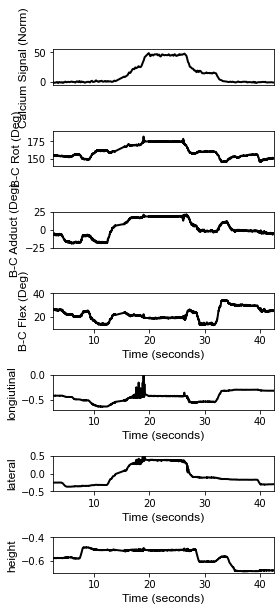

In [5]:
# fly 1, trial 1 looks good
flies = np.unique(pass_df['animal_id'])
fly = flies[5]
trials = np.unique(pass_df['trial'][pass_df['animal_id']==fly])
trial = trials[12]
filt_df = pass_df[(pass_df['animal_id']==fly) & (pass_df['trial']==trial)]

print('Fly: ', fly)
print('Trial: ', trial)

fig = plt.figure(1, figsize = [4,8])
# 4 subplots - activity and then each of the angles
plt.subplot(7,1,1) # activity
plt.plot(filt_df['time'].values, filt_df['activity'].values, color = 'black', linewidth = 2)
plt.ylabel('Calcium Signal (Norm)', fontsize = 12, fontname = 'arial')
# plt.xlabel('Time (seconds)', fontsize = 12, fontname = 'arial')
plt.xlim([filt_df['time'].values[0], filt_df['time'].values[-1]])
plt.yticks(fontsize = 10)
plt.ylim([-5, 55])
plt.xlim([2.5, 42.5])
plt.xticks([])

plt.subplot(7,1,2) # rotation
plt.plot(filt_df['time'].values, filt_df['L1A_rot'].values, color = 'black', linewidth = 2)
plt.ylabel('B-C Rot (Deg)', fontsize = 12, fontname = 'arial')
# plt.xlabel('Time (seconds)', fontsize = 12, fontname = 'arial')
plt.xlim([filt_df['time'].values[0], filt_df['time'].values[-1]])
plt.yticks(fontsize = 10)
plt.ylim([140, 190])
plt.xlim([2.5, 42.5])
plt.xticks([])

plt.subplot(7,1,3) # adduction
plt.plot(filt_df['time'].values, filt_df['L1A_abduct'].values, color = 'black', linewidth = 2)
plt.ylabel('B-C Adduct (Deg)', fontsize = 12, fontname = 'arial')
# plt.xlabel('Time (seconds)', fontsize = 12, fontname = 'arial')
plt.xlim([filt_df['time'].values[0], filt_df['time'].values[-1]])
plt.yticks(fontsize = 10)
plt.ylim([-25, 25])
plt.xlim([2.5, 42.5])
plt.xticks([])

plt.subplot(7,1,4) # flexion
plt.plot(filt_df['time'].values, filt_df['L1A_flex'].values, color = 'black', linewidth = 2)
plt.ylabel('B-C Flex (Deg)', fontsize = 12, fontname = 'arial')
plt.xlabel('Time (seconds)', fontsize = 12, fontname = 'arial')
plt.xlim([filt_df['time'].values[0], filt_df['time'].values[-1]])
plt.ylim([10, 40])
plt.xlim([2.5, 42.5])
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)

plt.subplot(7,1,5) # flexion
plt.plot(filt_df['time'].values, filt_df['L1E_x'].values, color = 'black', linewidth = 2)
plt.ylabel('longiutinal', fontsize = 12, fontname = 'arial')
plt.xlabel('Time (seconds)', fontsize = 12, fontname = 'arial')
plt.xlim([filt_df['time'].values[0], filt_df['time'].values[-1]])
plt.ylim([-0.7, 0])
plt.xlim([2.5, 42.5])
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)

plt.subplot(7,1,6) # flexion
plt.plot(filt_df['time'].values, filt_df['L1E_y'].values, color = 'black', linewidth = 2)
plt.ylabel('lateral', fontsize = 12, fontname = 'arial')
plt.xlabel('Time (seconds)', fontsize = 12, fontname = 'arial')
plt.xlim([filt_df['time'].values[0], filt_df['time'].values[-1]])
plt.ylim([-0.5, 0.5])
plt.xlim([2.5, 42.5])
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)

plt.subplot(7,1,7) # flexion
plt.plot(filt_df['time'].values, filt_df['L1E_z'].values, color = 'black', linewidth = 2)
plt.ylabel('height', fontsize = 12, fontname = 'arial')
plt.xlabel('Time (seconds)', fontsize = 12, fontname = 'arial')
plt.xlim([filt_df['time'].values[0], filt_df['time'].values[-1]])
plt.ylim([-0.7, -0.4])
plt.xlim([2.5, 42.5])
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)

plt.tight_layout()
plt.show()

# fig.savefig(save_dir+ 'passive_ex_2.png', dpi = 300)
# fig.savefig(save_dir+ 'passive_ex_2.svg', dpi = 300)

#### Mean activity w.r.t. joint angles

In [36]:
# create mean activity given joint angles
def mean_activity(angle, activity, n_bins, sample_threshold, sigma, angle_name):
    if angle_name == 'L1A_rot':
        min_angle = 80
        max_angle = 220
    elif angle_name == 'L1A_abduct':
        min_angle = -30
        max_angle = 30
    elif angle_name == 'L1A_flex':
        min_angle = 0
        max_angle = 60
    else:
        '''Min Max approach'''
        min_angle = np.min(angle)
        max_angle = np.max(angle)
    
    # remains the same
    bin_centers = np.linspace(min_angle, max_angle, n_bins)
    bin_width = bin_centers[1]-bin_centers[0]
    bin_edges = np.concatenate((bin_centers - (bin_width/2), np.array([bin_centers[-1] + (bin_width/2)])))
    ave_activity = np.zeros(n_bins)
    for i in range(n_bins):
        # only compute an average if there are enough data points
        curr_bool = np.logical_and(angle>bin_edges[i], angle<bin_edges[i+1])
        n_hits = len(np.where(curr_bool==True)[0])
        if n_hits > sample_threshold:
            ave_activity[i] = np.mean(activity[curr_bool])
            
    # correct bin centers and activity given that their was too little samples for a mean
#     bin_centers[ave_activity == 0] = np.nan
#     ave_activity[ave_activity == 0] = np.nan
    
    # remove zeros
    bin_centers = bin_centers[ave_activity != 0]
    ave_activity = ave_activity[ave_activity != 0]
    
    # interpolate data to bring back to 25 bins
    bins_interp = np.linspace(bin_centers[0], bin_centers[-1], n_bins)
    f = interpolate.interp1d(bin_centers, ave_activity)
    interp_activity = f(bins_interp)
    
    # smooth acitivty with a 1D guassian
    smoothed_acitivty = gaussian_filter1d(interp_activity, sigma)
    
    return bins_interp, smoothed_acitivty

In [37]:
joint_angles = ['L1A_rot', 'L1A_abduct', 'L1A_flex', 'L1B_flex', 'L1B_rot', 'L1C_flex', 'L1C_rot', 'L1D_flex']
flies = np.unique(pass_df['animal_id']).tolist()

# bin averaging
sigma = 1
n_bins = 25
sample_threshold = 50
ave_activity_store = np.zeros((len(flies), n_bins, 2, len(joint_angles))) # flies, bins, centers/vals, angle
activity_angle_corr = np.zeros((len(flies), len(joint_angles), 2)) # spearman or pearson r
max_activity_store = np.zeros((len(flies), len(joint_angles)))

# plot each 
# fig = plt.figure(1, figsize = [20, 25])

# activity of individual flies
plt_cnt = 0
fly_cnt = -1
for fly in flies:
    fly_cnt += 1
    angle_cnt = -1
    for angle in joint_angles:
        angle_cnt += 1
        # isolate calcium activity data and joint angles
        activity = pass_df['activity'][pass_df['animal_id']==fly].values
        angle_vals = pass_df[angle][pass_df['animal_id']==fly].values
        
        # find index of max acitivty
        max_idx = np.argmax(activity)
        max_activity_store[fly_cnt, angle_cnt] = angle_vals[max_idx]
        
        # find the mean activity
        bin_centers, ave_activity = mean_activity(angle_vals, activity, n_bins, sample_threshold, sigma, angle)
        ave_activity_store[fly_cnt, :, 0, angle_cnt] = bin_centers
        ave_activity_store[fly_cnt, :, 1, angle_cnt] = ave_activity
        
        activity_angle_corr[fly_cnt, angle_cnt, 0] = spearmanr(angle_vals, activity)[0] # spearman r correlation
        activity_angle_corr[fly_cnt, angle_cnt, 1] = pearsonr(angle_vals, activity)[0] # pearson r correlation
        
#         # plot individual fly activity versus joint angle
#         plt_cnt += 1
#         plt.subplot(len(flies), len(joint_angles), plt_cnt)
#         plt.plot(angle_vals, activity, marker = '.', markersize = 5, color = 'gray', linestyle = 'none')
#         plt.plot(bin_centers, ave_activity, color = 'black', linewidth = 2)
#         if fly == 1:
#             plt.title(angle, fontsize = 14, fontname = 'Arial')
            
#         if angle_cnt == 0:
#             plt.ylabel('fly '+ str(int(fly)), fontsize = 14, fontname = 'Arial')

# plt.tight_layout()
# plt.show()
# fig.savefig(save_dir+ 'fly_CoHP8_joint_encoding.png', dpi = 300)
# fig.savefig(save_dir+ 'fly_CoHP8_joint_encoding.pdf', dpi = 200) #too many data points

        
# global acitivity and angles
sample_threshold = 100
glob_activity_angles = np.zeros((len(joint_angles), n_bins, 2))
glob_correlation = np.zeros((2,len(joint_angles)))
glob_activity = pass_df['activity'].values
angle_cnt = -1
for angle in joint_angles:
    angle_cnt += 1
    glob_angles = pass_df[angle].values
    glob_correlation[0, angle_cnt] = spearmanr(glob_angles, glob_activity)[0] # spearman r correlation
    glob_correlation[1, angle_cnt] = pearsonr(glob_angles, glob_activity)[0] # pearson r correlation
    
    # mean acitivty
    bin_centers, ave_activity = mean_activity(glob_angles, glob_activity, n_bins, sample_threshold, sigma, angle)
    glob_activity_angles[angle_cnt, :, 0] = bin_centers
    glob_activity_angles[angle_cnt, :, 1] = ave_activity

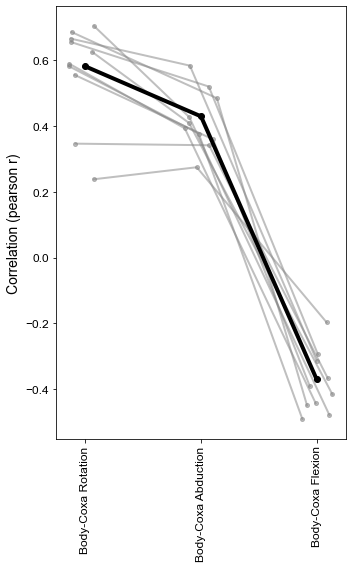

In [62]:
# correlation plot - spearman and pearson correlation coefs produce similar values
joint_angle_names = ['Body-Coxa Rotation', 'Body-Coxa Abduction', 'Body-Coxa Flexion',
                    'Coxa-Trochanter Flexion', 'Coxa-Trochanter Rotation', 'Femur-Tibia Flexion',
                     'Femur-Tibia Rotation', 'Tibia-Tarsus Flexion']

n_angles = 3
# plot
fig = plt.figure(1, figsize = [5,8])
for j in range(activity_angle_corr.shape[0]):
    x = np.arange(0,n_angles)+ np.random.choice([-1,1],size=n_angles)*np.random.uniform(low=0.0, high=0.15, size=n_angles)
    plt.plot(x, activity_angle_corr[j,0:n_angles,1], marker = '.', color = 'gray', markersize = 8, linewidth = 2, alpha = 0.5)
    
plt.plot(np.arange(0,n_angles), glob_correlation[1, 0:n_angles], color = 'black', marker = '.', markersize = 12, linewidth = 4)

plt.xticks(np.arange(0,n_angles), np.array(joint_angle_names[0:n_angles]), fontsize = 12, fontname = 'Arial', rotation = 90)
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.ylabel('Correlation (pearson r)', fontsize = 14, fontname = 'Arial')

plt.tight_layout()
plt.show()

fig.savefig(save_dir+ 'CoHP8_correlation.png', dpi = 300)
fig.savefig(save_dir+ 'CoHP8_correlation.svg', dpi = 300)


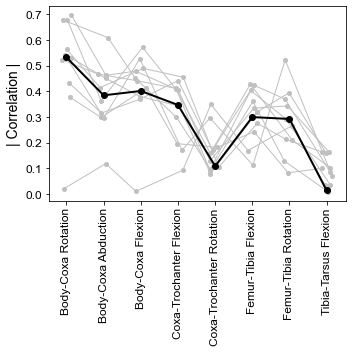

In [8]:
# correlation plot - spearman and pearson correlation coefs produce similar values
joint_angle_names = ['Body-Coxa Rotation', 'Body-Coxa Abduction', 'Body-Coxa Flexion',
                    'Coxa-Trochanter Flexion', 'Coxa-Trochanter Rotation', 'Femur-Tibia Flexion',
                     'Femur-Tibia Rotation', 'Tibia-Tarsus Flexion']

# plot
fig = plt.figure(1, figsize = [5,5])
for j in range(activity_angle_corr.shape[0]):
    x = np.arange(0,8)+ np.random.choice([-1,1],size=activity_angle_corr.shape[1])*np.random.uniform(low=0.0, high=0.15, size=activity_angle_corr.shape[1])
    plt.plot(x, np.abs(activity_angle_corr[j,:,0]), marker = '.', color = 'silver', markersize = 8, linewidth = 1)
    
plt.plot(np.arange(0,8), np.abs(glob_correlation[0, :]), color = 'black', marker = '.', markersize = 12, linewidth = 2)

plt.xticks(np.arange(0,8), np.array(joint_angle_names), fontsize = 12, fontname = 'Arial', rotation = 90)
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.ylabel('| Correlation |', fontsize = 14, fontname = 'Arial')

plt.tight_layout()
plt.show()

fig.savefig(save_dir+ 'CoHP8_abs_correlation.png', dpi = 300)
fig.savefig(save_dir+ 'CoHP8_abs_correlation.pdf', dpi = 300)

#### 1D joint angle encoding

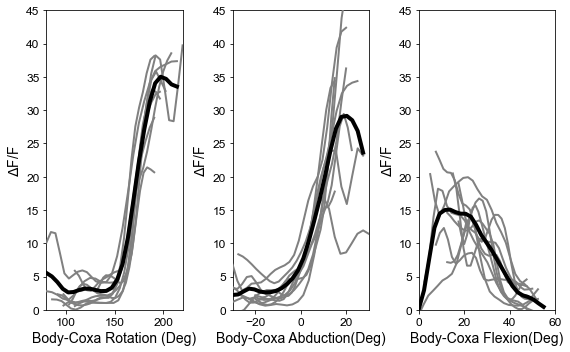

In [38]:
joint_plot_names = ['Body-Coxa Rotation (Deg)', 'Body-Coxa Abduction(Deg)', 'Body-Coxa Flexion(Deg)']
x_axes = [[80, 220], [-30, 30], [0, 60]]

fig = plt.figure(1, figsize = [8, 5])

for j in range(3):
    plt.subplot(1,3,j+1)
    
#     plt.scatter(pass_df[joint_angles[j]].values, pass_df['activity'].values, color ='lightgray', s = 5,  alpha =0.2, zorder = 1)
    
    for i in range(ave_activity_store.shape[0]):
        plt.plot(ave_activity_store[i,:,0,j], ave_activity_store[i,:,1,j], color = 'gray', linewidth = 2, zorder = 10)
        
    plt.plot(glob_activity_angles[j,:,0], glob_activity_angles[j,:,1], color ='black', linewidth = 4, zorder = 11)
    plt.xticks(fontsize = 12, fontname = 'Arial')
    plt.yticks(fontsize = 12, fontname = 'Arial')
    plt.ylabel(r'$\Delta$F/F', fontsize = 14, fontname = 'Arial')
    plt.xlabel(joint_plot_names[j], fontsize = 14, fontname = 'Arial')
    plt.xlim(x_axes[j])
    plt.ylim([0,45])
    
plt.tight_layout()
plt.show()

# fig.savefig(save_dir+ 'CoHP8_1d_encoding.png', dpi = 300)
# fig.savefig(save_dir+ '03092025_CoHP8_1d_encoding_lines.svg', dpi = 300)
fig.savefig(save_dir+ '03092025_CoHP8_1d_encoding_lines.pdf', dpi = 300)

#### 2D joint encoding

Need to distinguish between no activity from the angles that were explored

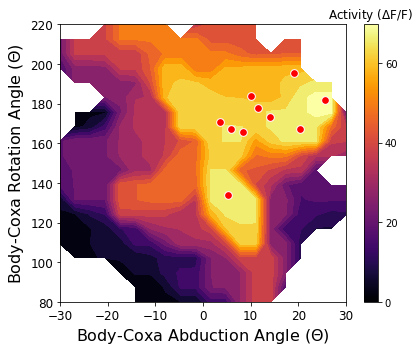

In [41]:
nlevels=20 # 20
grid_size = 20 # 75

# get global activity
activity = pass_df['activity'].values
rot_angle = pass_df[joint_angles[0]].values
abduct_angle = pass_df[joint_angles[1]].values

# set axes
rot_axis = np.linspace(80,220, grid_size)
dr = np.diff(rot_axis)[0]
adbuct_axis = np.linspace(-30, 30, grid_size)
da = np.diff(adbuct_axis)[0]
grid_abduct, grid_rot = np.meshgrid(adbuct_axis, rot_axis)
activity_2d_map = np.zeros((len(grid_abduct), len(grid_rot)))

# determine activity
for j in range(len(grid_abduct)):
    for i in range(len(grid_rot)):
        angle1_bool = np.logical_and(abduct_angle> adbuct_axis[j]-da, abduct_angle< adbuct_axis[j]+da)
        angle2_bool = np.logical_and(rot_angle> rot_axis[i]-dr, rot_angle< rot_axis[i]+dr)
        indices = np.logical_and(angle1_bool, angle2_bool)
        if np.any(indices):
            activity_2d_map[i,j] = np.max(activity[indices])
        else:
            activity_2d_map[i,j] = np.nan
            
# plot activity map
fig = plt.figure(1, figsize = [6, 5])

# global max values
CS2 = plt.contourf(grid_abduct, grid_rot, activity_2d_map, nlevels, cmap='inferno', vmin=0, vmax = 69.6919527858905)
CB2 = plt.colorbar(ScalarMappable(norm=CS2.norm, cmap=CS2.cmap),ticks=range(0, 80+nlevels, nlevels))
CB2.ax.set_title('Activity ($\Delta$F/F)')
plt.ylabel('Body-Coxa Rotation Angle ($\Theta$)', fontsize = 16)
plt.xlabel('Body-Coxa Abduction Angle ($\Theta$)', fontsize = 16)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

# plot fly anlges at max activity
plt.scatter(max_activity_store[:,1], max_activity_store[:,0], color = 'red', s = 60,edgecolors = 'white')

plt.tight_layout()
plt.show()

# save figure
# fig.savefig(save_dir+ 'CoHP8_2d_encoding.png', dpi = 300)
# fig.savefig(save_dir+ 'CoHP8_2d_encoding.svg', dpi = 300)
fig.savefig(save_dir+ '03092025_CoHP8_2d_encoding.pdf', dpi = 300)

### Activity during behavior (rest, forward walking, left or right turns, and grooming)

In [3]:
# isolate activity during behavior for each fly
def beh_activity(df):
    flies = np.unique(df['animal_id'].values)
    mean_fly_activity = np.zeros(len(flies))
    for j in range(len(flies)):
        activity = df['activity'][df['animal_id']==flies[j]].values
        mean_fly_activity[j] = np.mean(activity)

    activity_dist = df['activity'].values
    
    return activity_dist, mean_fly_activity

In [5]:
# isolate acitivty during behaviors
'''walking'''
walking_df = data[np.logical_and.reduce((data['analyze']==1, data['L1_other']==0, data['ball']==1, data['L1_walk']==1))].reset_index(drop=True)

# split walking into forward walking, left and right turning
vr_threshold = 25 # [deg/s]. Previously, 3 mm/s - rotational velocticity threshold # grant used 5 mm/s
vf_min_threshold = 5 # mm/s - minimum forward velocity threshold - z

# convert deg/s to rad/s to mm/s (arc length)
walking_df['vel_yaw'] = walking_df['vel_yaw'].values #*(np.pi/180) * 4.54  

fw_idxs = (walking_df['vel_forward'] >= vf_min_threshold) & (np.abs(walking_df['vel_yaw']) < vr_threshold)
lt_idxs = (walking_df['vel_forward'] >= vf_min_threshold) & (walking_df['vel_yaw'] > vr_threshold) # sign is already corrected
rt_idxs = (walking_df['vel_forward'] >= vf_min_threshold) & (walking_df['vel_yaw'] < -vr_threshold)

fw_df = walking_df[fw_idxs] # forward walking
lt_df = walking_df[lt_idxs] # left turns
rt_df = walking_df[rt_idxs] # right turns

'''grooming'''
grooming_df = data[np.logical_and.reduce((data['analyze']==1, data['ball']==1, data['L1_other']==0, data['L1_groom']==1))].reset_index(drop=True)

'''rest: split into passive and no passive angles'''
abduct_threshold = 0
resting_df = data[np.logical_and.reduce((data['analyze']==1, data['L1_other']==0, data['ball']==1, data['L1_rest']==1))].reset_index(drop=True)
resting_active = resting_df[resting_df['L1A_abduct']>abduct_threshold] #(resting_df['L1A_rot']>150) & 
resting_inactive = resting_df[resting_df['L1A_abduct']<abduct_threshold] #~(resting_df['L1A_rot']>150) &

In [7]:
# Activity during behaviors
rest_inactive_dist, rest_inactive_means = beh_activity(resting_inactive)
rest_active_dist, rest_active_means = beh_activity(resting_active)
groom_dist, groom_means = beh_activity(grooming_df)
fw_dist, fw_means = beh_activity(fw_df)
lt_dist, lt_means = beh_activity(lt_df)
rt_dist, rt_means = beh_activity(rt_df)

# concatenate distributions for plotting
dist_cat = np.concatenate((rest_inactive_dist, rest_active_dist, fw_dist, rt_dist, lt_dist, groom_dist))
id_cat = np.concatenate((np.ones(len(rest_inactive_dist)), 2*np.ones(len(rest_active_dist)), 3*np.ones(len(fw_dist)), 4*np.ones(len(rt_dist)), 5*np.ones(len(lt_dist)), 6*np.ones(len(groom_dist))))
cat_means = [rest_inactive_means, rest_active_means, fw_means, lt_means, rt_means, groom_means]

#### Example trial

Fly:  8.0
Trial:  20230120_A01_00012
L1_groom
L1_walk
L1_rest


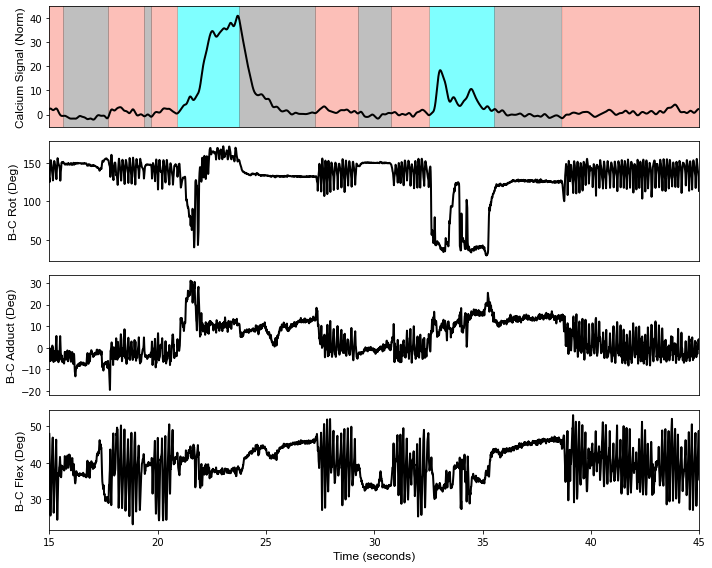

In [353]:
# example behavior df
ex_df = data[np.logical_and.reduce((data['analyze']==1, data['L1_other']==0, data['ball']==1))].reset_index(drop=True)

flies = np.unique(ex_df['animal_id'])
fly = flies[4]
trials = np.unique(ex_df['trial'][ex_df['animal_id']==fly])
trial = trials[11]
filt_df = ex_df[(ex_df['animal_id']==fly) & (ex_df['trial']==trial)]

print('Fly: ', fly)
print('Trial: ', trial)

# set plot params
x_start = 15 #filt_df['time'].values[0] #5 (4,4)
x_end = 45 #filt_df['time'].values[-1] #45(4,4)

# plot active
fig = plt.figure(1, figsize = [10,8])
# 4 subplots - activity and then each of the angles
plt.subplot(4,1,1) # activity
plt.plot(filt_df['time'].values, filt_df['activity'].values, color = 'black', linewidth = 2)
plt.ylabel('Calcium Signal (Norm)', fontsize = 12, fontname = 'arial')
# plt.xlabel('Time (seconds)', fontsize = 12, fontname = 'arial')

'''Add behaviors'''
time_array = filt_df['time'].values
beh_colors = ['cyan', 'salmon', 'gray']
cnt =-1
for beh in ['L1_groom', 'L1_walk', 'L1_rest']:
    print(beh)
    cnt +=1
    idxs = np.where(filt_df[beh] == 1)[0]
    diff_idxs = np.diff(idxs)
    transitions = np.where(diff_idxs>1)[0]
    if len(transitions) >0:
        if (len(idxs) > 0) and len(transitions) == 0: # if there is just one long bout
            plt.axvspan(time_array[idxs[0]], time_array[idxs[-1]], ymin=0, ymax=np.max(filt_df['activity'].values), color = beh_colors[cnt], alpha = 0.5)
        elif len(transitions) == 1: # just 2 bout:
            plt.axvspan(time_array[idxs[0]], time_array[idxs[transitions[0]]], ymin=0, ymax=np.max(filt_df['activity'].values), color = beh_colors[cnt], alpha = 0.5)
            plt.axvspan(time_array[idxs[transitions[0]+1]], time_array[idxs[-1]], ymin=0, ymax=np.max(filt_df['activity'].values), color = beh_colors[cnt], alpha = 0.5)
        else: # multiple bouts
            start_idx = idxs[0]
            for j in range(len(transitions)):
                if len(transitions)-1 == j:
                    end_idx = idxs[transitions[j]]
                    plt.axvspan(time_array[start_idx], time_array[end_idx], ymin=0, ymax=np.max(filt_df['activity'].values), color = beh_colors[cnt], alpha = 0.5)
                    plt.axvspan(time_array[idxs[transitions[j]+1]], time_array[idxs[-1]], ymin=0, ymax=np.max(filt_df['activity'].values), color = beh_colors[cnt], alpha = 0.5)
                else:
                    end_idx = idxs[transitions[j]]
                    plt.axvspan(time_array[start_idx], time_array[end_idx], ymin=0, ymax=np.max(filt_df['activity'].values), color = beh_colors[cnt], alpha = 0.5)
                    start_idx = idxs[transitions[j]+1]
                    
plt.xlim([x_start, x_end])
plt.ylim([-5,45])
plt.yticks(fontsize = 10)
plt.xticks([])


plt.subplot(4,1,2) # rotation
plt.plot(filt_df['time'].values, filt_df['L1A_rot'].values, color = 'black', linewidth = 2)
plt.ylabel('B-C Rot (Deg)', fontsize = 12, fontname = 'arial')
# plt.xlabel('Time (seconds)', fontsize = 12, fontname = 'arial')
plt.xlim([x_start, x_end])
plt.yticks(fontsize = 10)
plt.xticks([])

plt.subplot(4,1,3) # adduction
plt.plot(filt_df['time'].values, filt_df['L1A_abduct'].values, color = 'black', linewidth = 2)
plt.ylabel('B-C Adduct (Deg)', fontsize = 12, fontname = 'arial')
# plt.xlabel('Time (seconds)', fontsize = 12, fontname = 'arial')
plt.xlim([x_start, x_end])
plt.yticks(fontsize = 10)
plt.xticks([])

plt.subplot(4,1,4) # flexion
plt.plot(filt_df['time'].values, filt_df['L1A_flex'].values, color = 'black', linewidth = 2)
plt.ylabel('B-C Flex (Deg)', fontsize = 12, fontname = 'arial')
plt.xlabel('Time (seconds)', fontsize = 12, fontname = 'arial')
plt.xlim([x_start, x_end])
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)

plt.tight_layout()
plt.show()

fig.savefig(save_dir+ 'active_ex2.png', dpi = 300)
fig.savefig(save_dir+ 'active_ex2.svg', dpi = 300)
